In [1]:
# set environment and import packages
import os
from pandas import read_csv
import pandas as pd
import geopandas as gps
import matplotlib.pyplot as plt
import seaborn as sns
# import local python modules
# import constants_sf as c
import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')


plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

# mapping FAF mode to SynthFirm mode
mode_lookup = {1: 'Truck', 2: 'Rail', 3: 'Other', 4: 'Air', 
               5: 'Parcel', 6: 'Other', 7: 'Other', 8: 'Other'}

#define scenario input
analysis_year = 2017
us_ton_to_ton = 0.907185
miles_to_km = 1.60934
shipment_load_attr = 'tons_' + str(analysis_year)
shipment_tonmile_attr = 'tmiles_' + str(analysis_year)

plot_dir = 'plots_BayArea/'
output_dir = 'outputs_BayArea/'

This section load FAF data, aggregated CFS data, SCTG definition and geographic boundaries of study area

In [2]:
#load modeled, FAF and CFS results
# print(c.cfs_distribution_file)
faf_data = read_csv('Validation/' + 'FAF5.3.csv', sep = ',')
cfs_distribution = read_csv('Validation/' + 'cfs17_shpmt_dist_210916.csv', sep = ',')
modeled_data = read_csv('outputs_BayArea/' + 'processed_b2b_flow_summary.csv', sep = ',')
modeled_data = modeled_data.loc[modeled_data['mode_choice'] != 'Other']
#load parameters
sctg_group_lookup = read_csv('SynthFirm_parameters/' + 'SCTG_Groups_revised.csv', sep = ',')
mesozone_lookup = read_csv('inputs_BayArea/' + 'zonal_id_lookup_final.csv', sep = ',')
# sctg_definition = read_csv('SynthFirm_parameters/' + 'SCTG_definition.csv', sep = ',')
sctg_names = sctg_group_lookup['SCTG_Name'].unique()
sctg_group_definition = sctg_group_lookup.loc[:, ['SCTG_Group', 'SCTG_Name']]
sctg_group_definition = sctg_group_definition.drop_duplicates()

In [3]:
# process faf data for validation
faf_data.loc[:, 'mode_def'] = faf_data.loc[:, 'dms_mode'].map(mode_lookup)
# faf_data = pd.merge(faf_data, sctg_definition, left_on = 'sctg2', right_on = 'SCTG', how = 'left')
faf_data = pd.merge(faf_data, sctg_group_lookup, left_on = 'sctg2', right_on = 'SCTG_Code', how = 'left')
pd.options.mode.chained_assignment = None  # default='warn', turn off annoy warning messages
faf_data.loc[:, 'Distance'] = 1000 * faf_data.loc[:, shipment_tonmile_attr] / faf_data.loc[:, shipment_load_attr]
faf_data.loc[:, shipment_tonmile_attr] *= 1000000 
faf_data = faf_data.dropna(subset = ['Distance'])

trade_type_id = 1 # domestic only
faf_data_domestic = faf_data.loc[faf_data['trade_type'] == trade_type_id] #select domestic shipment only
faf_data_domestic = \
faf_data_domestic.loc[faf_data_domestic['mode_def'] != 'Other']
faf_data_domestic = \
faf_data_domestic.loc[faf_data_domestic['SCTG_Name'] != 'other']

region_code = [62, 64, 65, 69] 
faf_outflow = faf_data_domestic.loc[faf_data_domestic['dms_orig'].isin(region_code)]
faf_inflow = faf_data_domestic.loc[faf_data_domestic['dms_dest'].isin(region_code)]

faf_data.head(5)

,fr_orig,dms_orig,dms_dest,fr_dest,fr_inmode,dms_mode,fr_outmode,sctg2,trade_type,dist_band,...,tmiles_2045,tmiles_2050,mode_def,SCTG,Description_x,SCTG_Code,SCTG_Group,SCTG_Name,Description_y,Distance
0,NaN,11,11,NaN,NaN,1,NaN,1,1,1,...,9.571647,11.343818,Truck,1,Animals and Fish (live),1,3,interm_food,Animals and Fish (live),62.055473
1,NaN,11,19,NaN,NaN,1,NaN,1,1,2,...,116.602924,134.683927,Truck,1,Animals and Fish (live),1,3,interm_food,Animals and Fish (live),124.036282
2,NaN,11,129,NaN,NaN,1,NaN,1,1,3,...,0.750361,0.844720,Truck,1,Animals and Fish (live),1,3,interm_food,Animals and Fish (live),325.379820
3,NaN,11,131,NaN,NaN,1,NaN,1,1,2,...,3.850035,4.178881,Truck,1,Animals and Fish (live),1,3,interm_food,Animals and Fish (live),171.439975
4,NaN,11,139,NaN,NaN,1,NaN,1,1,2,...,2.456208,2.683008,Truck,1,Animals and Fish (live),1,3,interm_food,Animals and Fish (live),244.231728


In [4]:
### process CFS data
unique_region_names = \
mesozone_lookup.loc[mesozone_lookup['FAFID'].isin(region_code), 'FAFNAME'].unique()

cfs_distribution = \
pd.merge(cfs_distribution, sctg_group_definition, left_on = 'commodity', right_on = 'SCTG_Name', how = 'left')
cfs_distribution.loc[:, 'tonmile'] = \
1000 * cfs_distribution.loc[:, 'wgted_wght_ton_th'] * cfs_distribution.loc[:, 'SHIPMT_DIST_GC']

cfs_distribution_by_zone = \
cfs_distribution.groupby(['ORIG_NAME', 'DEST_NAME', 'commodity', 'SCTG_Group', 'mode_agg5'])[['wgted_wght_ton_th', 'tonmile']].sum()
cfs_distribution_by_zone = \
cfs_distribution_by_zone.reset_index()
cfs_distribution_by_zone.loc[:, 'SHIPMT_DIST_GC'] = \
cfs_distribution_by_zone.loc[:, 'tonmile'] / cfs_distribution_by_zone.loc[:, 'wgted_wght_ton_th'] / 1000

cfs_inflow = cfs_distribution_by_zone.loc[cfs_distribution_by_zone['DEST_NAME'].isin(unique_region_names)] 
cfs_outflow = cfs_distribution_by_zone.loc[cfs_distribution_by_zone['ORIG_NAME'].isin(unique_region_names)] 
cfs_distribution.head(5)

,WGT_FACTOR,ORIG_CFS_AREA,ORIG_NAME,DEST_CFS_AREA,DEST_NAME,SHIPMT_DIST_GC,commodity,naics_name,wght_ton_th,wgted_wght_ton_th,mode_agg5,SCTG_Group,SCTG_Name,tonmile
0,328.3,06-99999,Rest of CA,06-260,Fresno,54,other,Manufacturing,1.955000e-04,0.064183,Private Truck,5,other,3465.86310
1,20.9,06-260,Fresno,06-99999,Rest of CA,30,bulk,Mining,2.245600e-02,0.469330,Private Truck,1,bulk,14079.91200
2,339.7,06-488,San Francisco,48-206,Dallas,1453,mfr_goods,Manufacturing,5.000000e-07,0.000170,Parcel,4,mfr_goods,246.79205
3,9970.8,06-348,Los Angeles,06-472,Sacramento,390,other,Wholesale,2.370000e-04,2.363080,For-hire Truck,5,other,921601.04400
4,4881.1,06-488,San Francisco,25-148,Boston (MA),2669,mfr_goods,Wholesale,1.100000e-05,0.053692,Air,4,mfr_goods,143304.21490


In [5]:
# process modeled data
# modeled_data.loc[:, 'Distance'] = modeled_data.loc[:, 'tmiles'] / 1000 / modeled_data.loc[:, 'ShipmentLoad']
modeled_data = modeled_data.loc[modeled_data['SCTG_Name'] != 'other']
modeled_outflow = modeled_data.loc[modeled_data['outbound'] == 1]
modeled_inflow = modeled_data.loc[modeled_data['inbound'] == 1]
modeled_data.head(5)

,Unnamed: 0,orig_FAFID,orig_FAFNAME,dest_FAFID,dest_FAFNAME,SCTG_Group,SCTG_Name,mode_choice,tmiles,ShipmentLoad,count,outbound,inbound,Distance
0,0,11,Birmingham,65,Fresno,4,mfr_goods,Air,9.765312e+04,0.052278,53,0,1,1867.950344
1,1,11,Birmingham,65,Fresno,4,mfr_goods,For-hire Truck,7.080164e+06,2.842743,2882,0,1,2490.610000
2,2,11,Birmingham,65,Fresno,4,mfr_goods,Rail/IMX,1.955460e+05,0.074965,76,0,1,2608.500582
3,3,11,Birmingham,69,Rest of CA,4,mfr_goods,Air,5.556278e+03,0.002922,2,0,1,1901.411971
4,4,11,Birmingham,69,Rest of CA,4,mfr_goods,For-hire Truck,4.154133e+05,0.153415,105,0,1,2707.780000


interm_food


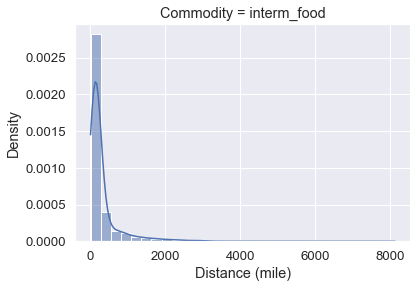

bulk


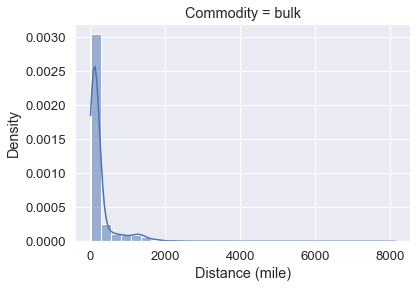

mfr_goods


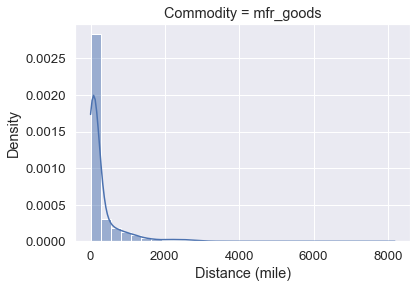

fuel_fert


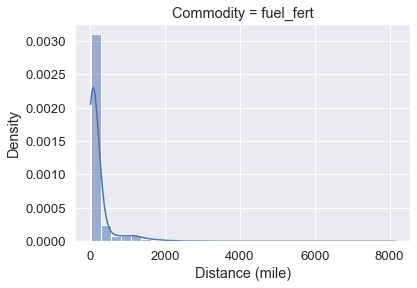

other


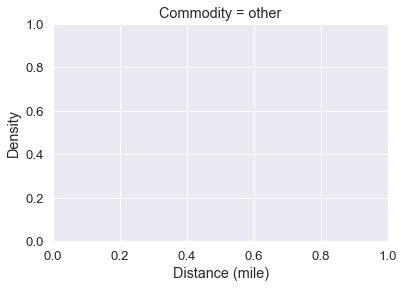

In [6]:
# generate FAF data descriptive statistics by commodity group
summary_statistics = {}
def summary_statistics_generator(data, tonmile_unit_factor = 1000000, shipment_load_unit_factor = 1000, 
                                 distance_var = 'Distance', load_var = 'weight', tonmile_var = 'tmiles'):
    mean_distance = (data[tonmile_var].sum() * tonmile_unit_factor) / \
    (data[load_var].sum() * shipment_load_unit_factor)
    max_distance = data.loc[data[load_var]>0, distance_var].max()
    min_distance = data.loc[data[load_var]>0, distance_var].min()
    data = data.sort_values(distance_var)
    data['weight'] = data[load_var].cumsum()
    cutoff = data[load_var].sum() / 2.0
    median_distance = data.loc[data['weight'] >= cutoff, distance_var].min()
    total_shipment_load = shipment_load_unit_factor * data[load_var].sum() # tons
    return(min_distance, max_distance, mean_distance, median_distance, total_shipment_load)
    
for sctg in sctg_names:
    print(sctg)
    faf_data_to_describe = faf_data_domestic.loc[faf_data_domestic['SCTG_Name'] == sctg]
    min_distance, max_distance, mean_distance, median_distance, total_shipment_load = \
    summary_statistics_generator(faf_data_to_describe, 1000000, 1000, 
                                 'Distance', shipment_load_attr, shipment_tonmile_attr)
    summary_statistics[sctg] = [min_distance, max_distance, mean_distance, median_distance]
    sns.histplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, bins = 30, 
             stat="density", kde = True, alpha=0.5)
    plt.title('Commodity = ' + sctg)
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.savefig(plot_dir + 'distance_distribution_for ' + sctg + '.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
summary_statistics_df = pd.DataFrame.from_dict(summary_statistics, orient='index',
                        columns=['min', 'max', 'mean', 'median']) 
summary_statistics_df.to_csv(output_dir + 'FAF_distance_statistics_by_sctg.csv')


In this section, we will compare shipment generation from FAF data, CFS data and modeled shipment data generated by SynthFirm. 

    -FAF: Only domestic shipment data will be selected from FAF.  
    -CFS: same aggregation level as FAF
    -SynthFirm: The SynthFirm modeled data will be filtered by study area.  The truck load will be scaled back to reflect the total shipment from all modes.

Truck


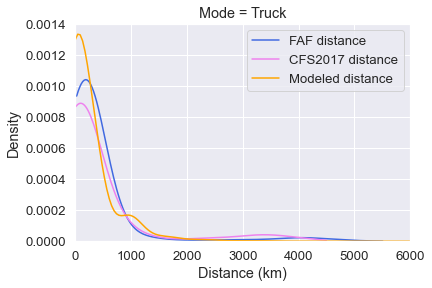

Rail


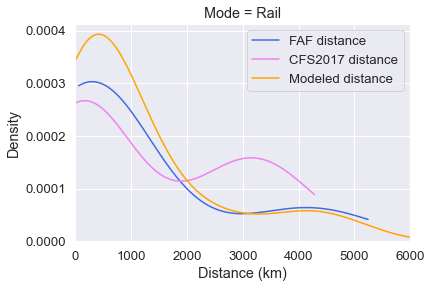

Air


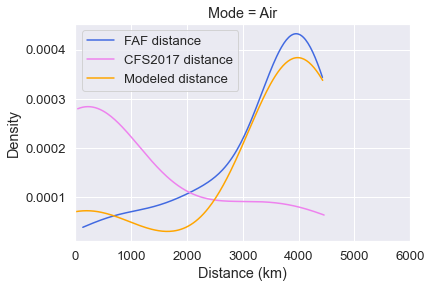

Parcel


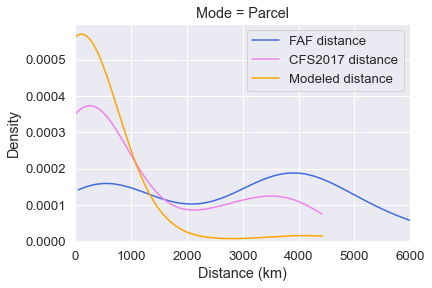

Truck


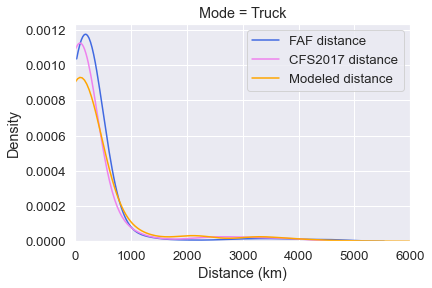

Rail


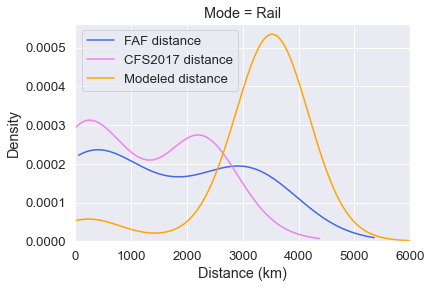

Air


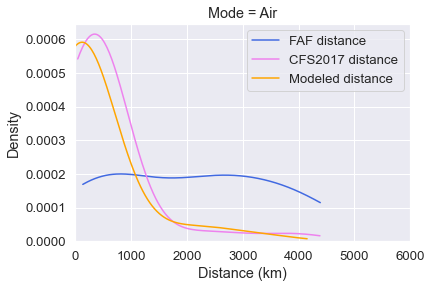

Parcel


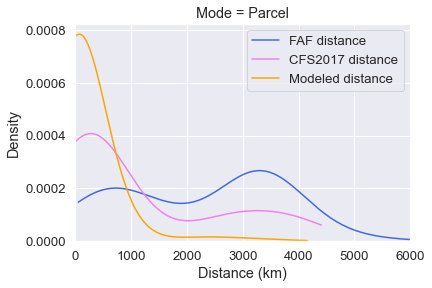

In [7]:
# compare travel distance by mode
modeled_statistics_mode = {}
FAF_mode_mapping = {'Truck':['For-hire Truck', 'Private Truck'], 
                    'Rail':['Rail/IMX'], 
                    'Air': ['Air'], 'Parcel':['Parcel']}
CFS_to_FAF_mapping = {'For-hire Truck':'Truck', 
                      'Private Truck': 'Truck', 
                      'Rail/IMX': 'Rail', 
                      'Air':'Air', 
                      'Parcel':'Parcel'}
mode_choice = modeled_data['mode_choice'].unique()


# production
modeled_statistics_mode = {}
for mode in ['Truck', 'Rail', 'Air', 'Parcel']:
    print(mode)
    mode_to_select = FAF_mode_mapping[mode]
    cfs_data_to_describe = cfs_outflow.loc[cfs_outflow['mode_agg5'].isin(mode_to_select)]
    modeled_data_to_describe = modeled_outflow.loc[modeled_outflow['mode_choice'].isin(mode_to_select)]
#     min_distance, max_distance, mean_distance, median_distance, total_shipment_load = \
#     summary_statistics_generator(modeled_data_to_describe, 1, 1000, 
#                                  'Distance', 'ShipmentLoad', 'tmiles')
#     modeled_statistics_mode[mode] = [min_distance, max_distance, mean_distance, median_distance, total_shipment_load]
    
    faf_data_to_describe = faf_outflow.loc[faf_outflow['mode_def'] == mode]
    faf_data_to_describe.loc[:, 'Distance'] *= miles_to_km
    cfs_data_to_describe.loc[:, 'SHIPMT_DIST_GC'] *= miles_to_km
    modeled_data_to_describe.loc[:, 'Distance'] *= miles_to_km
    sns.kdeplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, cut = 0,
            color = 'royalblue')    
    sns.kdeplot(data = cfs_data_to_describe, x= 'SHIPMT_DIST_GC', weights = 'wgted_wght_ton_th', cut = 0,
            color = 'violet')    
    sns.kdeplot(data = modeled_data_to_describe, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
            color = 'orange')
    plt.xlim([0, 6000])
    plt.legend(['FAF distance', 'CFS2017 distance', 'Modeled distance'])
    plt.title('Mode = ' + mode)
    plt.xlabel('Distance (km)')
    plt.ylabel('Density')
    plt.savefig(plot_dir + 'outflow_distance_comparison_for ' + mode + '.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
# modeled_statistics_mode_df = pd.DataFrame.from_dict(modeled_statistics_mode, orient='index',
#                         columns=['min', 'max', 'mean', 'median', 'load (ton)']) 
# modeled_statistics_mode_df.to_csv(c.output_dir + 'modeled_outflow_distance_statistics_by_mode.csv')

# attraction
for mode in ['Truck', 'Rail', 'Air', 'Parcel']:
    print(mode)
    mode_to_select = FAF_mode_mapping[mode]
    cfs_data_to_describe = cfs_inflow.loc[cfs_inflow['mode_agg5'].isin(mode_to_select)]
    modeled_data_to_describe = modeled_inflow.loc[modeled_inflow['mode_choice'].isin(mode_to_select)]
#     min_distance, max_distance, mean_distance, median_distance, total_shipment_load = \
#     summary_statistics_generator(modeled_data_to_describe, 1, 1000, 
#                                  'Distance', 'ShipmentLoad', 'tmiles')
#     modeled_statistics_mode[mode] = [min_distance, max_distance, mean_distance, median_distance, total_shipment_load]
 
    faf_data_to_describe = faf_inflow.loc[faf_inflow['mode_def'] == mode]
    faf_data_to_describe.loc[:, 'Distance'] *= miles_to_km
    cfs_data_to_describe.loc[:, 'SHIPMT_DIST_GC'] *= miles_to_km
    modeled_data_to_describe.loc[:, 'Distance'] *= miles_to_km   
    sns.kdeplot(data = faf_data_to_describe, x= 'Distance', weights = shipment_load_attr, cut = 0,
             color = 'royalblue')  
    sns.kdeplot(data = cfs_data_to_describe, x= 'SHIPMT_DIST_GC', weights = 'wgted_wght_ton_th', cut = 0,
             color = 'violet') 
    sns.kdeplot(data = modeled_data_to_describe, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
             color = 'orange')
    plt.xlim([0, 6000])
    plt.legend(['FAF distance', 'CFS2017 distance', 'Modeled distance'])
    plt.title('Mode = ' + mode)
    plt.xlabel('Distance (km)')
    plt.ylabel('Density')
    plt.savefig(plot_dir + 'inflow_distance_comparison_for ' + mode + '.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    
# modeled_statistics_mode_df = pd.DataFrame.from_dict(modeled_statistics_mode, orient='index',
#                         columns=['min', 'max', 'mean', 'median', 'load (ton)']) 
# modeled_statistics_mode_df.to_csv(c.output_dir + 'modeled_inflow_distance_statistics_by_mode.csv')

FAF shipment        360534.660363
CFS shipment        381578.567835
Modeled shipment    445237.574674
dtype: float64
FAF tonmile        113986.461682
CFS tonmile        125286.641390
Modeled tonmile     95205.930517
dtype: float64


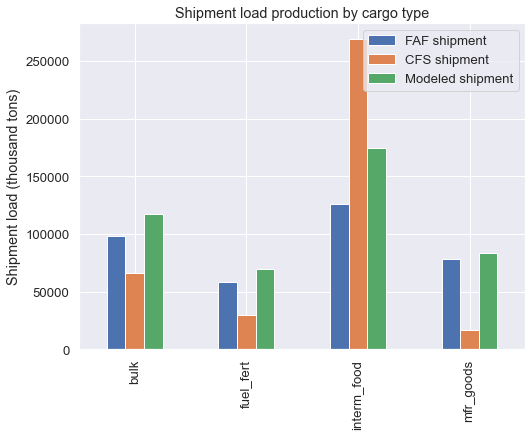

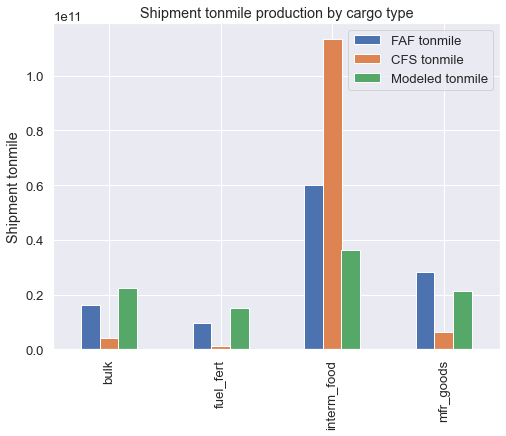

In [12]:
### plot shipment generation by commodity group
# data aggregation
FAF_shipment_by_sctg = faf_outflow.groupby('SCTG_Name')[[shipment_load_attr, shipment_tonmile_attr]].sum()
CFS_shipment_by_sctg = cfs_outflow.groupby('commodity')[['wgted_wght_ton_th', 'tonmile']].sum()
modeled_shipment_by_sctg = modeled_outflow.groupby('SCTG_Name')[['ShipmentLoad', 'tmiles']].sum()
shipment_generation_by_sctg = pd.merge(FAF_shipment_by_sctg, CFS_shipment_by_sctg, 
                                       left_index = True, right_index = True, how = 'left')
shipment_generation_by_sctg = pd.merge(shipment_generation_by_sctg, modeled_shipment_by_sctg, 
                                       left_index = True, right_index = True, how = 'left')
shipment_generation_by_sctg.columns = ['FAF shipment', 'FAF tonmile', 
                                       'CFS shipment', 'CFS tonmile',
                                       'Modeled shipment', 'Modeled tonmile']

# plot bar chart
shipment_generation_by_sctg.loc[:, 'FAF shipment'] *= us_ton_to_ton
shipment_generation_by_sctg.loc[:, 'CFS shipment'] *= us_ton_to_ton
shipment_generation_by_sctg.loc[:, 'Modeled shipment'] *= us_ton_to_ton

print(shipment_generation_by_sctg.loc[:, ['FAF shipment', 'CFS shipment', 'Modeled shipment']].sum())
print(shipment_generation_by_sctg.loc[:, ['FAF tonmile', 'CFS tonmile', 'Modeled tonmile']].sum()/1000000)

shipment_generation_by_sctg.plot(y = ['FAF shipment', 'CFS shipment', 'Modeled shipment'], 
                                 figsize = (8, 6), kind = 'bar',  
                                 title = 'Shipment load production by cargo type')
plt.xlabel('')
plt.ylabel('Shipment load (thousand tons)')
plt.legend(loc=1)
plt.savefig(plot_dir + 'outflow_shipment_comparison_by_sctg_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()


shipment_generation_by_sctg.plot(y = ['FAF tonmile', 'CFS tonmile', 'Modeled tonmile'], 
                                 figsize = (8, 6), kind = 'bar',  
                                 title = 'Shipment tonmile production by cargo type')
plt.xlabel('')
plt.ylabel('Shipment tonmile')
plt.legend(loc=1)
plt.savefig(plot_dir + 'outflow_tonmile_comparison_by_sctg_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()

shipment_generation_by_sctg.to_csv(output_dir + 'outbound_shipment_by_sctg.csv')

In [13]:
modeled_shipment_by_sctg

,ShipmentLoad,tmiles
SCTG_Name,,
bulk,129600.914207,2.236462e+10
fuel_fert,76846.846495,1.520209e+10
interm_food,192287.934877,3.644035e+10
mfr_goods,92054.578371,2.119887e+10


FAF shipment        364278.389461
CFS shipment        377214.270294
Modeled shipment    499947.409126
dtype: float64
FAF tonmile        123233.236883
CFS tonmile        103336.383094
Modeled tonmile    270376.366378
dtype: float64


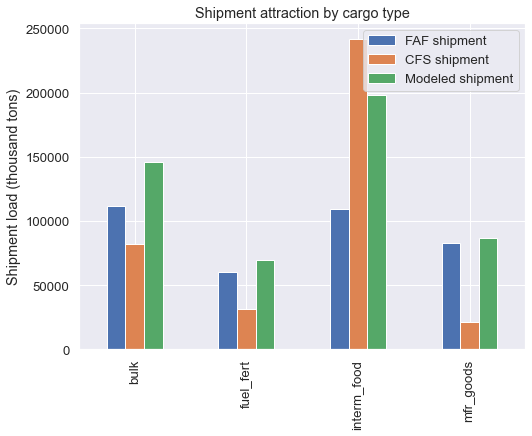

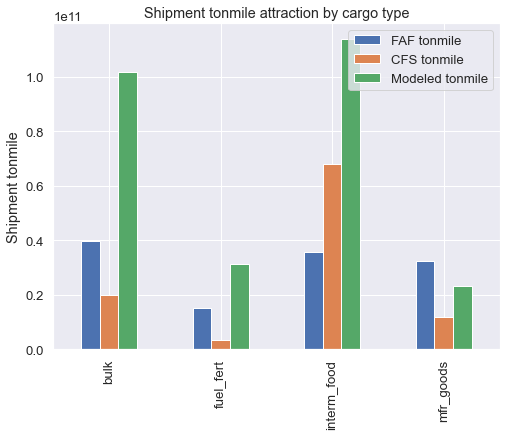

In [11]:
### plot shipment generation by commodity group
# data aggregation
FAF_shipment_by_sctg = faf_inflow.groupby('SCTG_Name')[[shipment_load_attr, shipment_tonmile_attr]].sum()
CFS_shipment_by_sctg = cfs_inflow.groupby('commodity')[['wgted_wght_ton_th', 'tonmile']].sum()
modeled_shipment_by_sctg = modeled_inflow.groupby('SCTG_Name')[['ShipmentLoad', 'tmiles']].sum()
shipment_attraction_by_sctg = pd.merge(FAF_shipment_by_sctg, CFS_shipment_by_sctg, 
                                       left_index = True, right_index = True, how = 'left')
shipment_attraction_by_sctg = pd.merge(shipment_attraction_by_sctg, modeled_shipment_by_sctg, 
                                       left_index = True, right_index = True, how = 'left')
shipment_attraction_by_sctg.columns = ['FAF shipment', 'FAF tonmile', 
                                       'CFS shipment', 'CFS tonmile',
                                       'Modeled shipment', 'Modeled tonmile']

shipment_attraction_by_sctg.loc[:, 'FAF shipment'] *= us_ton_to_ton
shipment_attraction_by_sctg.loc[:, 'CFS shipment'] *= us_ton_to_ton
shipment_attraction_by_sctg.loc[:, 'Modeled shipment'] *= us_ton_to_ton

print(shipment_attraction_by_sctg.loc[:, ['FAF shipment', 'CFS shipment', 'Modeled shipment']].sum())
print(shipment_attraction_by_sctg.loc[:, ['FAF tonmile', 'CFS tonmile', 'Modeled tonmile']].sum()/1000000)
# plot bar chart
shipment_attraction_by_sctg.plot(y = ['FAF shipment', 'CFS shipment', 'Modeled shipment'], 
                                 figsize = (8, 6), kind = 'bar',  title = 'Shipment attraction by cargo type')
plt.xlabel('')
plt.ylabel('Shipment load (thousand tons)')
plt.legend(loc=1)
plt.savefig(plot_dir + 'inflow_shipment_comparison_by_sctg_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()

shipment_attraction_by_sctg.plot(y = ['FAF tonmile', 'CFS tonmile', 'Modeled tonmile'], 
                                 figsize = (8, 6), kind = 'bar',  
                                 title = 'Shipment tonmile attraction by cargo type')
plt.xlabel('')
plt.ylabel('Shipment tonmile')
plt.legend(loc=1)
plt.savefig(plot_dir + 'inflow_tonmile_comparison_by_sctg_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()

shipment_attraction_by_sctg.to_csv(output_dir + 'inbound_shipment_by_sctg.csv')

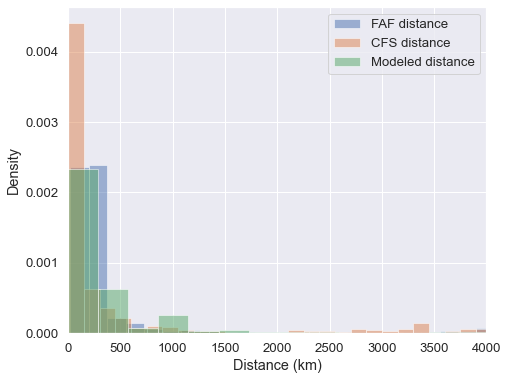

37        24.143476
40         0.000050
41         0.000050
42        13.217751
43         0.000052
            ...    
492625     0.000132
492626     0.001984
492627     0.000050
492628     0.125833
492629     0.000111
Name: tons_2017, Length: 16172, dtype: float64


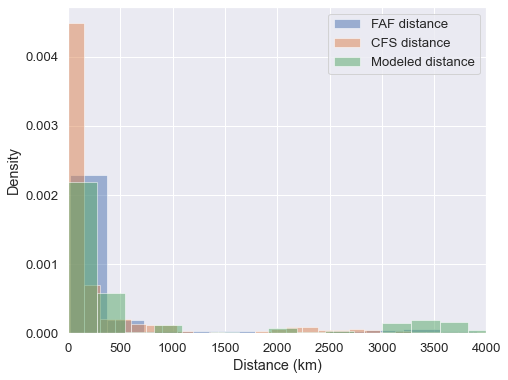

In [10]:
### plot shipment distance distribution
# generation
plt.figure(figsize=(7.5,6))
faf_outflow['Distance'] *= miles_to_km
cfs_outflow['SHIPMT_DIST_GC'] *= miles_to_km
modeled_outflow['Distance'] *= miles_to_km
faf_outflow['Distance'].plot(kind = "hist", weights = faf_outflow[shipment_load_attr], 
                                  alpha = 0.5, bins = 60, density = True)
cfs_outflow['SHIPMT_DIST_GC'].plot(kind = "hist", weights = cfs_outflow['wgted_wght_ton_th'], 
                                  alpha = 0.5, bins = 30, density = True)
modeled_outflow['Distance'].plot(kind = "hist", weights = modeled_outflow['ShipmentLoad'], 
                                          alpha = 0.5, bins = 30, density = True)
plt.legend(['FAF distance', 'CFS distance', 'Modeled distance'])
plt.xlabel('Distance (km)')
plt.ylabel('Density')
plt.xlim([0, 4000])
plt.savefig(plot_dir + 'outflow_distance_comparison_cfs_added.png', bbox_inches = 'tight', dpi = 200)
plt.show()

# attraction
plt.figure(figsize=(7.5,6))
print(faf_inflow[shipment_load_attr])
faf_inflow['Distance'] *= miles_to_km
cfs_inflow['SHIPMT_DIST_GC'] *= miles_to_km
modeled_inflow['Distance'] *= miles_to_km
# bay_area_inflow = bay_area_inflow.dropna(subset = ['Distance', shipment_load_attr])
faf_inflow['Distance'].plot(kind = "hist", weights = faf_inflow[shipment_load_attr], 
                                  alpha = 0.5, bins = 30, density = True)
cfs_inflow['SHIPMT_DIST_GC'].plot(kind = "hist", weights = cfs_inflow['wgted_wght_ton_th'], 
                                  alpha = 0.5, bins = 30, density = True)
#plt.show()
modeled_inflow['Distance'].plot(kind = "hist", weights = modeled_inflow['ShipmentLoad'], 
                                          alpha = 0.5, bins = 30, density = True)
plt.legend(['FAF distance', 'CFS distance', 'Modeled distance'])
plt.xlabel('Distance (km)')
plt.ylabel('Density')
plt.xlim([0, 4000])
plt.savefig(plot_dir + 'inflow_distance_comparison_cfs_added.png', bbox_inches = 'tight', dpi = 200)
plt.show()

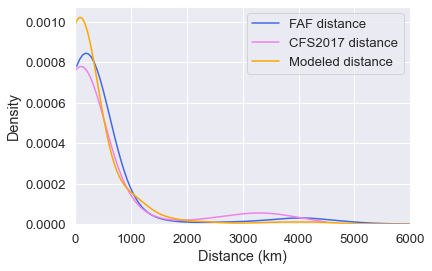

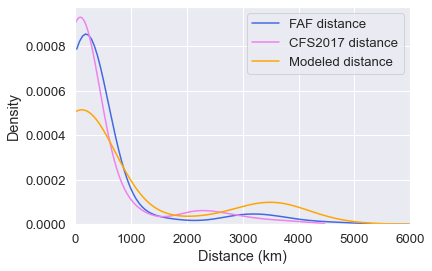

In [11]:
#KDE plot
sns.kdeplot(data = faf_outflow, x= 'Distance', weights = shipment_load_attr, cut = 0,
             color = 'royalblue')  
sns.kdeplot(data = cfs_outflow, x= 'SHIPMT_DIST_GC', weights = 'wgted_wght_ton_th', cut = 0,
             color = 'violet') 
sns.kdeplot(data = modeled_outflow, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
             color = 'orange')
plt.xlim([0, 6000])
plt.legend(['FAF distance', 'CFS2017 distance', 'Modeled distance'])
plt.xlabel('Distance (km)')
plt.ylabel('Density')
plt.savefig(plot_dir + 'outflow_distance_comparison_kde.png', bbox_inches = 'tight', dpi = 200)
plt.show()


sns.kdeplot(data = faf_inflow, x= 'Distance', weights = shipment_load_attr, cut = 0,
             color = 'royalblue')  
sns.kdeplot(data = cfs_inflow, x= 'SHIPMT_DIST_GC', weights = 'wgted_wght_ton_th', cut = 0,
             color = 'violet') 
sns.kdeplot(data = modeled_inflow, x= 'Distance', weights = 'ShipmentLoad', cut = 0,
             color = 'orange')
plt.xlim([0, 6000])
plt.legend(['FAF distance', 'CFS2017 distance', 'Modeled distance'])
plt.xlabel('Distance (km)')
plt.ylabel('Density')
plt.savefig(plot_dir + 'inflow_distance_comparison_kde.png', bbox_inches = 'tight', dpi = 200)
plt.show()

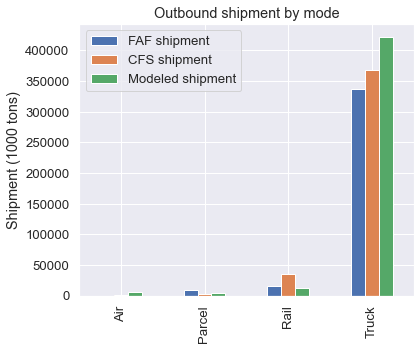

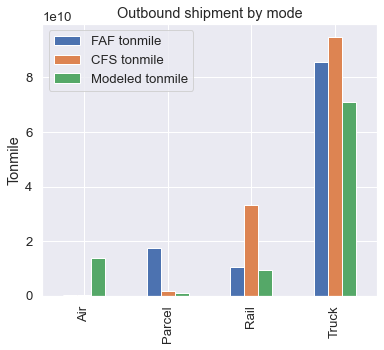

In [14]:
# plot shipment production by mode choice
cfs_outflow.loc[:, 'mode_def'] = cfs_outflow.loc[:, 'mode_agg5'].map(CFS_to_FAF_mapping)
modeled_outflow.loc[:, 'mode_def'] = modeled_outflow.loc[:, 'mode_choice'].map(CFS_to_FAF_mapping)
    
agg_faf_outflow_by_mode = faf_outflow.groupby(['mode_def'])[[shipment_load_attr, shipment_tonmile_attr]].sum()
agg_faf_outflow_by_mode = agg_faf_outflow_by_mode.reset_index()
cfs_outflow_by_mode = cfs_outflow.groupby(['mode_def'])[['wgted_wght_ton_th', 'tonmile']].sum()
cfs_outflow_by_mode = cfs_outflow_by_mode.reset_index()
agg_modeled_outflow_by_mode = modeled_outflow.groupby(['mode_def'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_outflow_by_mode = agg_modeled_outflow_by_mode.reset_index()
compare_outflow_by_mode = pd.merge(agg_faf_outflow_by_mode, agg_modeled_outflow_by_mode, 
                                         on = ['mode_def'], how = 'left')
compare_outflow_by_mode = pd.merge(compare_outflow_by_mode, cfs_outflow_by_mode, 
                                         on = ['mode_def'], how = 'left')
compare_outflow_by_mode.head(5)
compare_outflow_by_mode.columns = ['mode_def', 'FAF shipment', 'FAF tonmile',                                       
                                  'Modeled shipment', 'Modeled tonmile',
                                  'CFS shipment', 'CFS tonmile']
compare_outflow_by_mode['FAF shipment'] *= us_ton_to_ton
compare_outflow_by_mode['Modeled shipment'] *= us_ton_to_ton
compare_outflow_by_mode['CFS shipment'] *= us_ton_to_ton
compare_outflow_by_mode = compare_outflow_by_mode.loc[compare_outflow_by_mode['mode_def'] != 'Other']
# compare_outflow_by_mode = compare_outflow_by_mode.rename(columns={shipment_load_attr:'FAF shipment', 
#                                                                               'ShipmentLoad':'modeled shipment',
#                                                                              'wgted_wght_ton_th':'CFS shipment'})
compare_outflow_by_mode.plot(x= 'mode_def', 
                             y = ['FAF shipment', 'CFS shipment', 'Modeled shipment'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Outbound shipment by mode')

plt.xlabel('')
plt.ylabel('Shipment (1000 tons)')
plt.legend(loc=2)
plt.savefig(plot_dir + 'outflow_shipment_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()


compare_outflow_by_mode.plot(x= 'mode_def', 
                             y = ['FAF tonmile', 'CFS tonmile', 'Modeled tonmile'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Outbound shipment by mode')

plt.xlabel('')
plt.ylabel('Tonmile')
plt.legend(loc=2)
plt.savefig(plot_dir + 'outflow_tonmile_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()
compare_outflow_by_mode.to_csv(output_dir + 'outflow_shipment_by_mode_comparison.csv')

Index(['mode_choice', 'ShipmentLoad', 'tmiles', 'fraction_x', 'mode_agg5',
       'wgted_wght_ton_th', 'tonmile', 'fraction_y'],
      dtype='object')


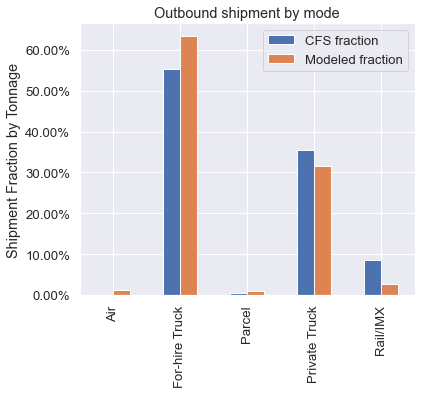

Index(['mode_choice', 'ShipmentLoad', 'tmiles', 'fraction_x', 'mode_agg5',
       'wgted_wght_ton_th', 'tonmile', 'fraction_y'],
      dtype='object')


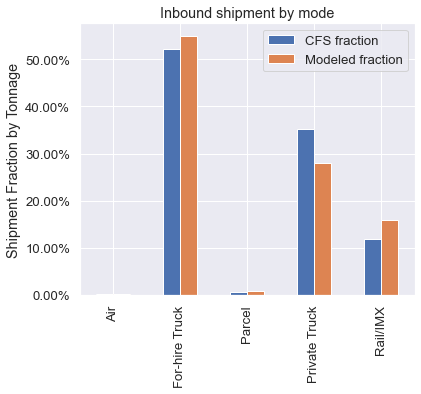

      mode_choice  Modeled shipment  Modeled tonmile  Modeled fraction  \
0             Air       6608.231063     1.396873e+10          0.013464   
1  For-hire Truck     310737.288051     6.621350e+10          0.633137   
2          Parcel       5198.579314     9.289146e+08          0.010592   
3   Private Truck     154792.997589     4.733043e+09          0.315395   
4        Rail/IMX      13453.177933     9.361750e+09          0.027411   

        mode_agg5   CFS shipment   CFS tonmile  CFS fraction  
0             Air     468.295802  3.159585e+08      0.001050  
1  For-hire Truck  246814.767467  8.833827e+10      0.553138  
2          Parcel    2392.820305  1.860887e+09      0.005363  
3   Private Truck  158147.569991  6.563056e+09      0.354426  
4        Rail/IMX   38384.716045  3.311677e+10      0.086024  
      mode_choice  Modeled shipment  Modeled tonmile  Modeled fraction  \
0             Air        976.568013     2.225308e+08          0.001772   
1  For-hire Truck     302585.

In [15]:
# plot shipment production by mode choice -- 5 mode version
import matplotlib.ticker as mtick
cfs_outflow_by_5mode = cfs_outflow.groupby(['mode_agg5'])[['wgted_wght_ton_th', 'tonmile']].sum()
cfs_outflow_by_5mode = cfs_outflow_by_5mode.reset_index()

cfs_outflow_by_5mode.loc[:, 'fraction'] = cfs_outflow_by_5mode.loc[:, 'wgted_wght_ton_th'] / \
cfs_outflow_by_5mode.loc[:, 'wgted_wght_ton_th'].sum()
agg_modeled_outflow_by_5mode = modeled_outflow.groupby(['mode_choice'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_outflow_by_5mode = agg_modeled_outflow_by_5mode.reset_index()
agg_modeled_outflow_by_5mode.loc[:, 'fraction'] = agg_modeled_outflow_by_5mode.loc[:, 'ShipmentLoad'] / \
agg_modeled_outflow_by_5mode.loc[:, 'ShipmentLoad'].sum()
compare_outflow_by_5mode = pd.merge(agg_modeled_outflow_by_5mode, cfs_outflow_by_5mode, 
                                   left_on = ['mode_choice'], 
                                   right_on = 'mode_agg5', how = 'left')
print(compare_outflow_by_5mode.columns)
compare_outflow_by_5mode.columns = ['mode_choice',                                       
                                  'Modeled shipment', 'Modeled tonmile', 'Modeled fraction',
                                    'mode_agg5', 
                                  'CFS shipment', 'CFS tonmile','CFS fraction']
                                                                           
ax = compare_outflow_by_5mode.plot(x= 'mode_choice', 
                             y = ['CFS fraction', 'Modeled fraction'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Outbound shipment by mode')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.xlabel('')
plt.ylabel('Shipment Fraction by Tonnage')
plt.legend(loc=1)
plt.savefig(plot_dir + 'outflow_shipment_comparison_by_5mode.png', bbox_inches='tight', dpi = 300)
plt.show()


# plot shipment production by mode choice -- 5 mode version
cfs_inflow_by_5mode = cfs_inflow.groupby(['mode_agg5'])[['wgted_wght_ton_th', 'tonmile']].sum()
cfs_inflow_by_5mode = cfs_inflow_by_5mode.reset_index()
cfs_inflow_by_5mode.loc[:, 'fraction'] = cfs_inflow_by_5mode.loc[:, 'wgted_wght_ton_th'] / \
cfs_inflow_by_5mode.loc[:, 'wgted_wght_ton_th'].sum()

agg_modeled_inflow_by_5mode = modeled_inflow.groupby(['mode_choice'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_inflow_by_5mode = agg_modeled_inflow_by_5mode.reset_index()
agg_modeled_inflow_by_5mode.loc[:, 'fraction'] = agg_modeled_inflow_by_5mode.loc[:, 'ShipmentLoad'] / \
agg_modeled_inflow_by_5mode.loc[:, 'ShipmentLoad'].sum()

compare_inflow_by_5mode = pd.merge(agg_modeled_inflow_by_5mode, cfs_inflow_by_5mode, 
                                   left_on = ['mode_choice'], 
                                   right_on = 'mode_agg5', how = 'left')
print(compare_inflow_by_5mode.columns)
compare_inflow_by_5mode.columns = ['mode_choice',                                       
                                  'Modeled shipment', 'Modeled tonmile', 'Modeled fraction',
                                    'mode_agg5', 
                                  'CFS shipment', 'CFS tonmile', 'CFS fraction']
                                                                           
ax = compare_inflow_by_5mode.plot(x= 'mode_choice', 
                             y = ['CFS fraction', 'Modeled fraction'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Inbound shipment by mode')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

plt.xlabel('')
plt.ylabel('Shipment Fraction by Tonnage')
plt.legend(loc=1)
plt.savefig(plot_dir + 'inflow_shipment_comparison_by_5mode.png', bbox_inches='tight', dpi = 300)
plt.show()
print(compare_outflow_by_5mode)
print(compare_inflow_by_5mode)


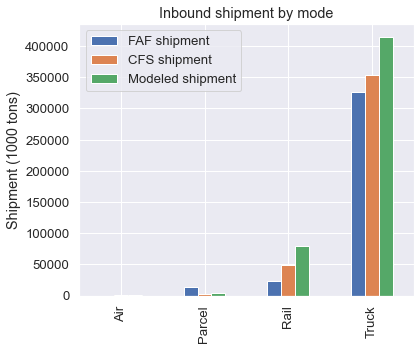

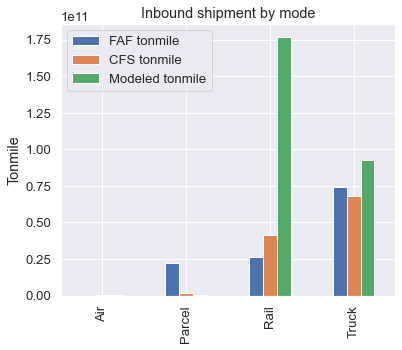

In [16]:
# plot shipment attraction by mode choice
cfs_inflow.loc[:, 'mode_def'] = cfs_inflow.loc[:, 'mode_agg5'].map(CFS_to_FAF_mapping)
modeled_inflow.loc[:, 'mode_def'] = modeled_inflow.loc[:, 'mode_choice'].map(CFS_to_FAF_mapping)
    
agg_faf_inflow_by_mode = faf_inflow.groupby(['mode_def'])[[shipment_load_attr, shipment_tonmile_attr]].sum()
agg_faf_inflow_by_mode = agg_faf_inflow_by_mode.reset_index()
cfs_inflow_by_mode = cfs_inflow.groupby(['mode_def'])[['wgted_wght_ton_th', 'tonmile']].sum()
cfs_inflow_by_mode = cfs_inflow_by_mode.reset_index()
agg_modeled_inflow_by_mode = modeled_inflow.groupby(['mode_def'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_inflow_by_mode = agg_modeled_inflow_by_mode.reset_index()
compare_inflow_by_mode = pd.merge(agg_faf_inflow_by_mode, agg_modeled_inflow_by_mode, 
                                         on = ['mode_def'], how = 'left')
compare_inflow_by_mode = pd.merge(compare_inflow_by_mode, cfs_inflow_by_mode, 
                                         on = ['mode_def'], how = 'left')
compare_inflow_by_mode.head(5)
compare_inflow_by_mode.columns = ['mode_def', 'FAF shipment', 'FAF tonmile',                                       
                                  'Modeled shipment', 'Modeled tonmile',
                                  'CFS shipment', 'CFS tonmile']
compare_inflow_by_mode['FAF shipment'] *= us_ton_to_ton
compare_inflow_by_mode['Modeled shipment'] *= us_ton_to_ton
compare_inflow_by_mode['CFS shipment'] *= us_ton_to_ton

compare_inflow_by_mode = compare_inflow_by_mode.loc[compare_inflow_by_mode['mode_def'] != 'Other']
# compare_outflow_by_mode = compare_outflow_by_mode.rename(columns={shipment_load_attr:'FAF shipment', 
#                                                                               'ShipmentLoad':'modeled shipment',
#                                                                              'wgted_wght_ton_th':'CFS shipment'})
compare_inflow_by_mode.plot(x= 'mode_def', 
                            y = ['FAF shipment', 'CFS shipment', 'Modeled shipment'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Inbound shipment by mode')

plt.xlabel('')
plt.ylabel('Shipment (1000 tons)')
plt.legend(loc=2)
plt.savefig(plot_dir + 'inflow_shipment_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()


compare_inflow_by_mode.plot(x= 'mode_def', 
                             y = ['FAF tonmile', 'CFS tonmile', 'Modeled tonmile'], 
                            figsize = (6, 5), kind = 'bar',  
                            title = 'Inbound shipment by mode')

plt.xlabel('')
plt.ylabel('Tonmile')
plt.legend(loc=2)
plt.savefig(plot_dir + 'inflow_tonmile_comparison_by_mode.png', bbox_inches='tight', dpi = 300)
plt.show()
compare_inflow_by_mode.to_csv(output_dir + 'inflow_shipment_by_mode_comparison.csv')

   orig_FAFID   orig_FAFNAME   ShipmentLoad
0          62     Sacramento   54286.772606
1          64  San Francisco  210462.186213
2          65         Fresno   46306.720546
3          69     Rest of CA  179734.594584


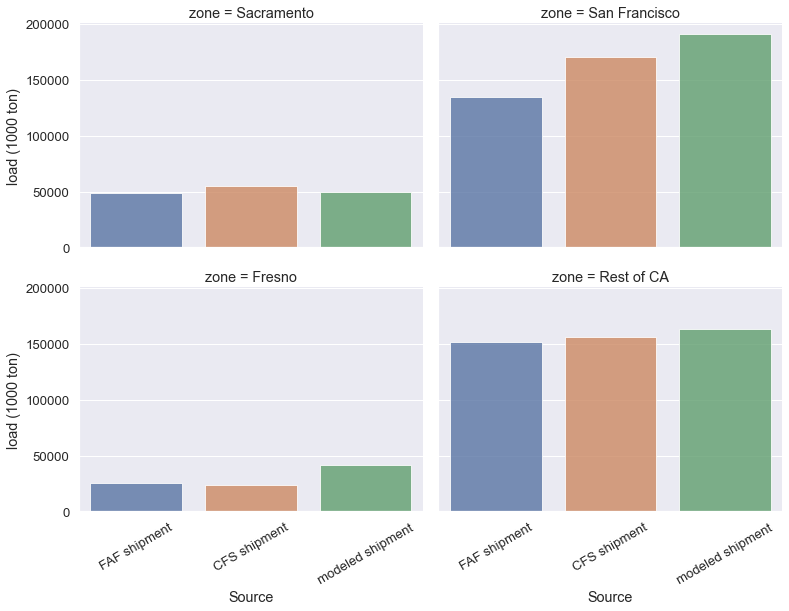

In [17]:
# plot shipment comparison by origin FAF zone and commodity group
agg_faf_outflow_by_zone = faf_outflow.groupby(['dms_orig'])[[shipment_load_attr]].sum()
agg_faf_outflow_by_zone = agg_faf_outflow_by_zone.reset_index()
cfs_outflow_by_zone = cfs_outflow.groupby(['ORIG_NAME'])[['wgted_wght_ton_th']].sum()
agg_modeled_outflow_by_zone = modeled_outflow.groupby(['orig_FAFID', 'orig_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_outflow_by_zone = agg_modeled_outflow_by_zone.reset_index()
print(agg_modeled_outflow_by_zone)
                                                                      
compare_outflow_by_zone = pd.merge(agg_faf_outflow_by_zone, agg_modeled_outflow_by_zone, 
                                         left_on = ['dms_orig'], right_on = ['orig_FAFID'], how = 'left')
compare_outflow_by_zone = pd.merge(compare_outflow_by_zone, cfs_outflow_by_zone, 
                                         left_on = ['orig_FAFNAME'], right_on = ['ORIG_NAME'], how = 'left')
compare_outflow_by_zone = compare_outflow_by_zone.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                              'ShipmentLoad':'modeled shipment',
                                                                             'wgted_wght_ton_th':'CFS shipment'})
compare_outflow_by_zone = pd.melt(compare_outflow_by_zone, 
                                    id_vars=['dms_orig', 'orig_FAFID', 'orig_FAFNAME'], 
                                    value_vars=['FAF shipment', 'CFS shipment', 'modeled shipment'], 
                                    var_name = 'Source', ignore_index=False)
# print(compare_outflow_by_zone.head(5))

compare_outflow_by_zone = compare_outflow_by_zone.rename(columns = {'orig_FAFNAME': 'zone',
                                                                   'value': 'load (1000 ton)'})
compare_outflow_by_zone['load (1000 ton)'] *= us_ton_to_ton
ax = sns.catplot(
    data= compare_outflow_by_zone, kind="bar",
    x="Source", y="load (1000 ton)", col = 'zone', col_wrap = 2,
    alpha=.8, height=4, aspect=1.4
)
ax.set_xticklabels(rotation=30) 
plt.savefig(plot_dir + 'outflow_shipment_by_zone_cfs_added.png', bbox_inches='tight', dpi = 300)
# plt.ylabel('Shipment load (1000 tons)')
plt.show()
compare_outflow_by_zone.to_csv(output_dir + 'compare_outflow_by_zone_cfs_dded.csv', sep = ',')

   dest_FAFID   dest_FAFNAME   ShipmentLoad
0          62     Sacramento   50569.326867
1          64  San Francisco  264805.730226
2          65         Fresno   20071.438260
3          69     Rest of CA  215651.030648


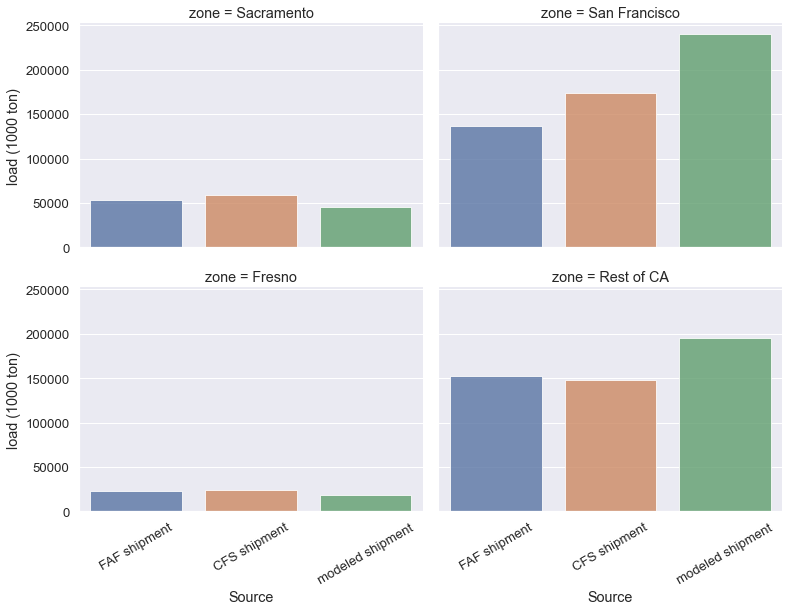

In [18]:
# plot shipment comparison by origin FAF zone and commodity group
agg_faf_inflow_by_zone = faf_inflow.groupby(['dms_dest'])[[shipment_load_attr]].sum()
agg_faf_inflow_by_zone = agg_faf_inflow_by_zone.reset_index()
cfs_inflow_by_zone = cfs_inflow.groupby(['DEST_NAME'])[['wgted_wght_ton_th']].sum()
agg_modeled_inflow_by_zone = modeled_inflow.groupby(['dest_FAFID', 'dest_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_inflow_by_zone = agg_modeled_inflow_by_zone.reset_index()
print(agg_modeled_inflow_by_zone)
                                                                      
compare_inflow_by_zone = pd.merge(agg_faf_inflow_by_zone, agg_modeled_inflow_by_zone, 
                                         left_on = ['dms_dest'], right_on = ['dest_FAFID'], how = 'left')
compare_inflow_by_zone = pd.merge(compare_inflow_by_zone, cfs_inflow_by_zone, 
                                         left_on = ['dest_FAFNAME'], right_on = ['DEST_NAME'], how = 'left')
compare_inflow_by_zone = compare_inflow_by_zone.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                              'ShipmentLoad':'modeled shipment',
                                                                             'wgted_wght_ton_th':'CFS shipment'})
compare_inflow_by_zone = pd.melt(compare_inflow_by_zone, 
                                        id_vars=['dms_dest', 'dest_FAFID', 'dest_FAFNAME'], 
                                        value_vars=['FAF shipment', 'CFS shipment', 'modeled shipment'], 
                                        var_name = 'Source', ignore_index=False)
# print(compare_inflow_by_zone.head(5))

compare_inflow_by_zone = compare_inflow_by_zone.rename(columns = {'dest_FAFNAME': 'zone',
                                                                   'value': 'load (1000 ton)'})
compare_inflow_by_zone['load (1000 ton)'] *= us_ton_to_ton
ax = sns.catplot(
    data= compare_inflow_by_zone, kind="bar",
    x="Source", y="load (1000 ton)", col = 'zone', col_wrap = 2,
    alpha=.8, height=4, aspect=1.4
)
ax.set_xticklabels(rotation=30) 
plt.savefig(plot_dir + 'inflow_shipment_by_zone_cfs_added.png', bbox_inches='tight', dpi = 300)
plt.show()
compare_inflow_by_zone.to_csv(output_dir + 'compare_inflow_by_zone_cfs_dded.csv', sep = ',')

In this section, we will compare the shipment distribution (O-D flow) among FAF data, CFS data and model output. Two types of comparisons will be generated in this process:

    - Shipment comparison by origin/destination (showing top 20 origins/destinations)
    - Comparison of shipment distance distributions


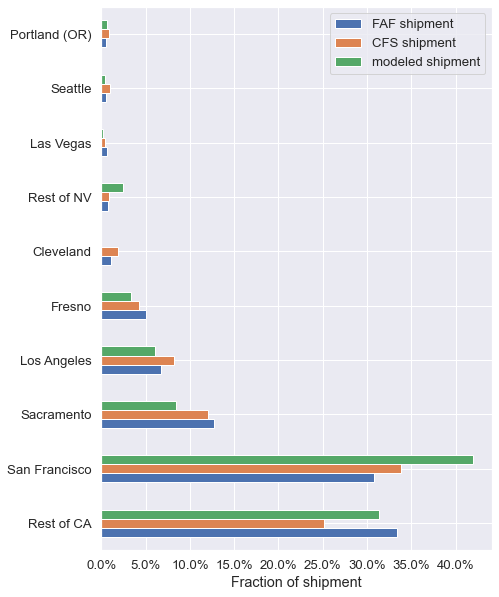

In [19]:
# plot outflow distance and tonnage distribution
nzones = 10
agg_faf_outflow_by_destination = faf_outflow.groupby(['dms_dest'])[[shipment_load_attr]].sum()
agg_faf_outflow_by_destination = agg_faf_outflow_by_destination.reset_index()
agg_modeled_outflow_destination = modeled_outflow.groupby(['dest_FAFID', 'dest_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_outflow_destination = agg_modeled_outflow_destination.reset_index()
cfs_outflow_destination = cfs_outflow.groupby(['DEST_NAME'])[['wgted_wght_ton_th']].sum()
                                                                      
compare_outflow_by_destination = pd.merge(agg_faf_outflow_by_destination, agg_modeled_outflow_destination, 
                                         left_on = ['dms_dest'], right_on = ['dest_FAFID'], how = 'left')

compare_outflow_by_destination = pd.merge(compare_outflow_by_destination, cfs_outflow_destination, 
                                         left_on = ['dest_FAFNAME'], right_on = ['DEST_NAME'], how = 'left')

compare_outflow_by_destination = compare_outflow_by_destination.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                                'ShipmentLoad':'modeled shipment',
                                                                                'wgted_wght_ton_th':'CFS shipment'})
compare_outflow_by_destination.loc[:, 'FAF shipment'] = compare_outflow_by_destination.loc[:, 'FAF shipment'] / compare_outflow_by_destination.loc[:, 'FAF shipment'].sum()
compare_outflow_by_destination.loc[:, 'modeled shipment'] = compare_outflow_by_destination.loc[:, 'modeled shipment'] / compare_outflow_by_destination.loc[:, 'modeled shipment'].sum()
compare_outflow_by_destination.loc[:, 'CFS shipment'] = compare_outflow_by_destination.loc[:, 'CFS shipment'] / compare_outflow_by_destination.loc[:, 'CFS shipment'].sum()
# sns.scatterplot(data=compare_outflow_by_destination, x="FAF_shipment", y="modeled_shipment")
# plot load assignment (top 20 zones)
compare_outflow_by_destination = compare_outflow_by_destination.sort_values('FAF shipment', ascending = False)
compare_outflow_by_destination_to_plot = compare_outflow_by_destination.head(nzones)
ax = compare_outflow_by_destination_to_plot.plot.barh(x='dest_FAFNAME', y=['FAF shipment', 'CFS shipment', 'modeled shipment'], 
                                         figsize = (7,10), rot = 0)
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.1%}'.format(x) for x in vals])
plt.xlabel('Fraction of shipment')
plt.ylabel('')
plt.savefig(plot_dir + 'percent_outflow_load_comparison_cfs_added.png', bbox_inches = 'tight', dpi = 200)
plt.show()


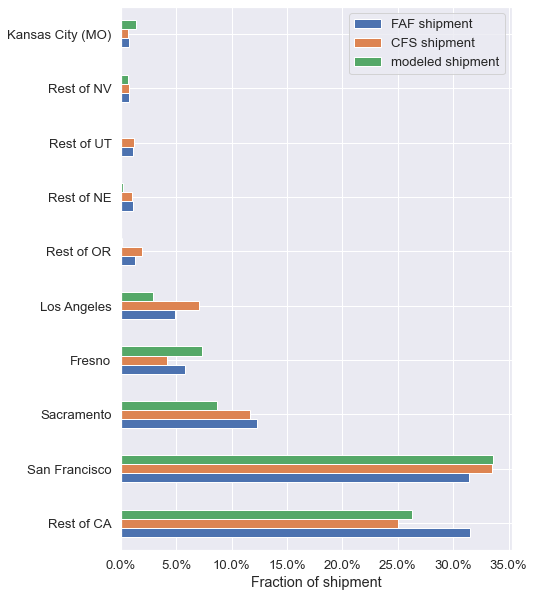

In [20]:
# plot inflow distance and tonnage distribution
nzones = 10
agg_faf_inflow_by_origin = faf_inflow.groupby(['dms_orig'])[[shipment_load_attr]].sum()
agg_faf_inflow_by_origin = agg_faf_inflow_by_origin.reset_index()
agg_modeled_inflow_origin = modeled_inflow.groupby(['orig_FAFID', 'orig_FAFNAME'])[['ShipmentLoad']].sum()
agg_modeled_inflow_origin = agg_modeled_inflow_origin.reset_index()
cfs_inflow_destination = cfs_inflow.groupby(['ORIG_NAME'])[['wgted_wght_ton_th']].sum()
                                                                      
compare_inflow_by_origin = pd.merge(agg_faf_inflow_by_origin, agg_modeled_inflow_origin, 
                                         left_on = ['dms_orig'], right_on = ['orig_FAFID'], how = 'left')

compare_inflow_by_origin = pd.merge(compare_inflow_by_origin, cfs_inflow_destination, 
                                         left_on = ['orig_FAFNAME'], right_on = ['ORIG_NAME'], how = 'left')

compare_inflow_by_origin = compare_inflow_by_origin.rename(columns={shipment_load_attr:'FAF shipment', 
                                                                                'ShipmentLoad':'modeled shipment',
                                                                                'wgted_wght_ton_th':'CFS shipment'})


compare_inflow_by_origin.loc[:, 'FAF shipment'] = compare_inflow_by_origin.loc[:, 'FAF shipment'] / compare_inflow_by_origin.loc[:, 'FAF shipment'].sum()
compare_inflow_by_origin.loc[:, 'modeled shipment'] = compare_inflow_by_origin.loc[:, 'modeled shipment'] / compare_inflow_by_origin.loc[:, 'modeled shipment'].sum()
compare_inflow_by_origin.loc[:, 'CFS shipment'] = compare_inflow_by_origin.loc[:, 'CFS shipment'] / compare_inflow_by_origin.loc[:, 'CFS shipment'].sum()
# plot load assignment (top 20 zones)
compare_inflow_by_origin = compare_inflow_by_origin.sort_values('FAF shipment', ascending = False)
compare_inflow_by_origin_to_plot = compare_inflow_by_origin.head(nzones)
ax = compare_inflow_by_origin_to_plot.plot.barh(x='orig_FAFNAME', y=['FAF shipment', 'CFS shipment', 'modeled shipment'], 
                                         figsize = (7,10), rot = 0)
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.1%}'.format(x) for x in vals])
plt.xlabel('Fraction of shipment')
plt.ylabel('')
plt.savefig(plot_dir + 'percent_inflow_load_comparison_cfs_added.png', bbox_inches = 'tight', dpi = 200)
plt.show()


In [19]:
# Generate distance and tonnage distribution by commodity groups and origins
agg_faf_inflow_by_origin = bay_area_inflow.groupby(['dms_orig', 'SCTG_Group', \
                                                           'SCTG_Name'])[[shipment_load_attr, shipment_tonmile_attr]].sum()
agg_faf_inflow_by_origin = agg_faf_inflow_by_origin.reset_index()
agg_modeled_inflow_origin = modeled_bay_area_inflow.groupby(['orig_FAFID', 'orig_FAFNAME', \
                                                                    'SCTG_Group', 'SCTG_Name'])[['ShipmentLoad', 'tmiles']].sum()
agg_modeled_inflow_origin = agg_modeled_inflow_origin.reset_index()

agg_cfs_inflow_origin = cfs_inflow.groupby(['ORIG_NAME','SCTG_Group', 'commodity'])[['wgted_wght_ton_th', 'tonmile']].sum()
agg_cfs_inflow_origin = agg_cfs_inflow_origin.reset_index()

compare_inflow_by_origin = pd.merge(agg_faf_inflow_by_origin, agg_modeled_inflow_origin, 
                                         left_on = ['dms_orig', 'SCTG_Group', 'SCTG_Name'], 
                                          right_on = ['orig_FAFID', 'SCTG_Group', 'SCTG_Name'], how = 'left')
compare_inflow_by_origin = pd.merge(compare_inflow_by_origin, agg_cfs_inflow_origin, 
                                         left_on = ['orig_FAFNAME', 'SCTG_Group', 'SCTG_Name'], 
                                          right_on = ['ORIG_NAME', 'SCTG_Group', 'commodity'], how = 'left')

compare_inflow_by_origin = compare_inflow_by_origin.rename(columns={shipment_load_attr:'FAF_shipment',
                                                                                shipment_tonmile_attr:'FAF_tonmile',
                                                                                'ShipmentLoad':'modeled_shipment',
                                                                               'tmiles': 'modeled_tonmile',
                                                                               'wgted_wght_ton_th': 'CFS_shipment', 
                                                                                'tonmile':'CFS_tonmile'})
compare_inflow_by_origin.loc[:, 'FAF_avg_dist'] = 1000 * compare_inflow_by_origin.loc[:, 'FAF_tonmile'] / \
compare_inflow_by_origin.loc[:, 'FAF_shipment'] 
compare_inflow_by_origin.loc[:, 'CFS_avg_dist'] = compare_inflow_by_origin.loc[:, 'CFS_tonmile'] / \
compare_inflow_by_origin.loc[:, 'CFS_shipment'] 
compare_inflow_by_origin.loc[:, 'Modeled_avg_dist'] = compare_inflow_by_origin.loc[:, 'modeled_tonmile'] / \
compare_inflow_by_origin.loc[:, 'modeled_shipment'] / 1000 
compare_inflow_by_origin.loc[:, 'modeled_tonmile'] /= 1000000 # 1 million tmile
compare_inflow_by_origin.to_csv(c.output_dir + 'compare_distribution_by_origin_cargo.csv', 
                                      sep = ',', index = False)

interm_food


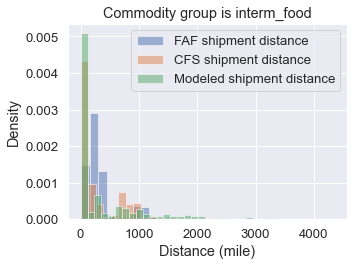

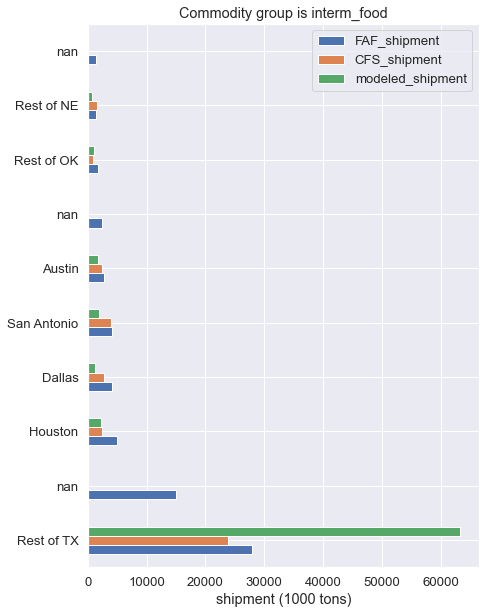

bulk


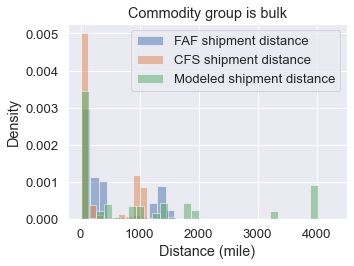

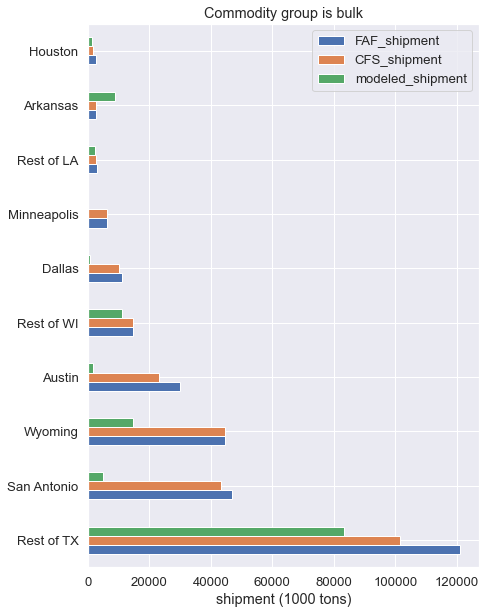

mfr_goods


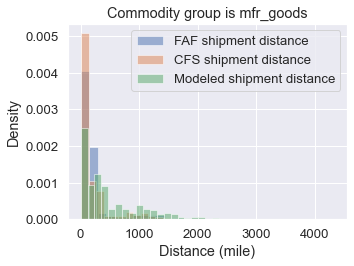

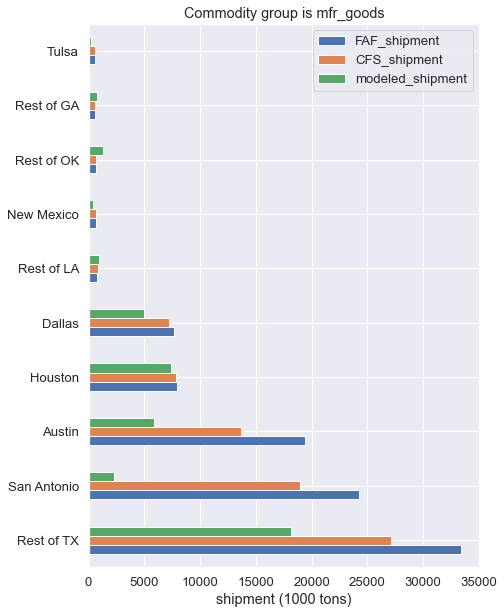

fuel_fert


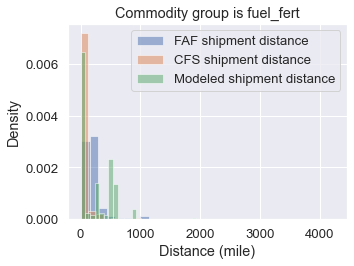

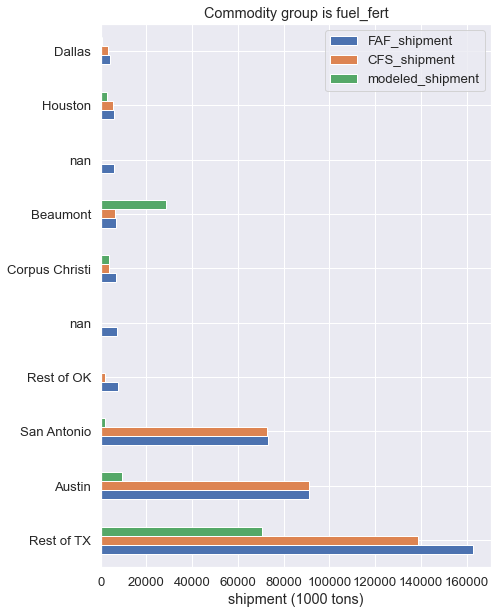

other


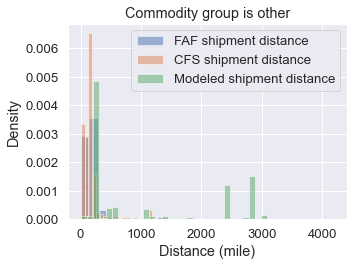

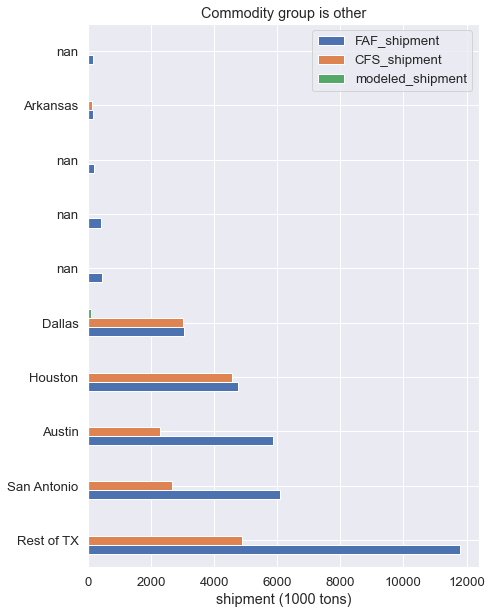

In [20]:
# plot inflow distance and tonnage distribution by commodity groups
for sctg in sctg_names:
    print(sctg)
    plt.figure(figsize=(5,3.6))
    bay_area_inflow_by_sctg = bay_area_inflow.loc[bay_area_inflow['SCTG_Name'] == sctg]
    bay_area_inflow_by_sctg['Distance'].plot(kind = "hist", weights = bay_area_inflow_by_sctg[shipment_load_attr], 
                                      alpha = 0.5, bins = 30, density=True)
    cfs_inflow_by_sctg = cfs_inflow.loc[cfs_inflow['commodity'] == sctg]
    cfs_inflow_by_sctg['SHIPMT_DIST_GC'].plot(kind = "hist", weights = cfs_inflow_by_sctg['wgted_wght_ton_th'], 
                                      alpha = 0.5, bins = 30, density=True)
    modeled_bay_area_inflow_by_sctg = modeled_bay_area_inflow.loc[modeled_bay_area_inflow['SCTG_Name'] == sctg]
    modeled_bay_area_inflow_by_sctg['Distance'].plot(kind="hist", weights = modeled_bay_area_inflow_by_sctg['ShipmentLoad'], 
                                              alpha =0.5, bins = 30, density=True)
    plt.legend(['FAF shipment distance', 'CFS shipment distance', 'Modeled shipment distance'])
    plt.xlabel('Distance (mile)')
    plt.ylabel('Density')
    plt.title('Commodity group is ' + sctg)
    plt.savefig('plot/inflow_distance_comparison_' + sctg + '_cfs_added.png', bbox_inches = 'tight', dpi = 200)
    plt.show()
    # plot load assignment (top 10 zones)
    compare_inflow_by_origin_sctg = compare_inflow_by_origin.loc[compare_inflow_by_origin['SCTG_Name'] == sctg]
    compare_inflow_by_origin_sctg = compare_inflow_by_origin_sctg.sort_values('FAF_shipment', ascending = False)
    compare_inflow_by_origin_sctg_to_plot = compare_inflow_by_origin_sctg.head(nzones)
    compare_inflow_by_origin_sctg_to_plot.plot.barh(x='orig_FAFNAME', y=['FAF_shipment','CFS_shipment', 'modeled_shipment'], 
                                             figsize = (7,10), rot = 0)
    plt.xlabel('shipment (1000 tons)')
    plt.ylabel('')
    plt.title('Commodity group is ' + sctg)           
    plt.savefig('plot/inflow_load_comparison_' + sctg + '_cfs_added.png', bbox_inches = 'tight', dpi = 200)
    plt.show()